<a href="https://colab.research.google.com/github/mille-s/Build_KGs_entities/blob/main/DBpedia_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Clones, Installs and functions
from IPython.display import clear_output, HTML, display
import os
! pip install SPARQLWrapper

# Clone Build_KGs_entities repo
! git clone https://github.com/mille-s/Build_KGs_entities.git
# Delete locally to avoid confusion
! rm '/content/Build_KGs_entities/DBpedia_dataset.ipynb'

# clone wikipedia page generator repo
! git clone https://github.com/mille-s/WikipediaPage_Generator.git
# Delete locally to avoid confusion
! rm 'WikipediaPage_Generator/Wikipedia_generator.ipynb'

# clone dcu_tcd_webnlg repo
! git clone https://github.com/mille-s/DCU_TCD_FORGe_WebNLG23.git
# Delete locally to avoid confusion
! rm 'DCU_TCD_FORGe_WebNLG23/DCU_TCD_FORGe_WebNLG23.ipynb'

props_list_path = os.path.join('/content', 'DCU_TCD_FORGe_WebNLG23', 'code', 'sorted_properties.txt')

triple2predArg = os.path.join('/content', 'XML')
os.makedirs(triple2predArg)

def aggregate_info_and_get_propLabel(ontology_properties):
  dico_properties = {}
  for prop in ontology_properties:
    # Get raw labels without the url part
    _ , property_no_prefix = os.path.split(prop['property'])
    domain_no_prefix = 'Unknown'
    if not prop['domain'] == 'Unknown':
      _ , domain_no_prefix = os.path.split(prop['domain'])
    range_no_prefix = 'Unknown'
    if not prop['range'] == 'Unknown':
      _ , range_no_prefix = os.path.split(prop['range'])
    # The first time a property is found, create a dico entry with domain and range info
    if property_no_prefix not in dico_properties.keys():
      dico_properties[property_no_prefix] = {'domain': [domain_no_prefix], 'range': [range_no_prefix]}
    # The second time, only append the domain and range if they haven't been seen to this point
    else:
      if domain_no_prefix not in dico_properties[property_no_prefix]['domain']:
        dico_properties[property_no_prefix]['domain'].append(domain_no_prefix)
      if range_no_prefix not in dico_properties[property_no_prefix]['range']:
        dico_properties[property_no_prefix]['range'].append(range_no_prefix)
  return dico_properties

clear_output()
print('Working folder ready!\n--------------')

Working folder ready!
--------------


# Preliminary work: get info to build datasets

In [ ]:
#@title SPARQL query to get all properties in DBpedia (from ChatGPT)

from SPARQLWrapper import SPARQLWrapper, JSON

def getDBpediaProperties():
  # Set up the SPARQL endpoint
  sparql = SPARQLWrapper("http://dbpedia.org/sparql")

  # Define the SPARQL query to retrieve properties with the prefix "http://dbpedia.org/ontology"
  query = """
  SELECT DISTINCT ?property
  WHERE {
    ?property a rdf:Property .
    FILTER(STRSTARTS(STR(?property), "http://dbpedia.org/ontology/"))
  }
  ORDER BY ?property
  """

  # Set the query
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)

  try:
      # Execute the query
      results = sparql.query().convert()

      # Process and display the results
      properties = [result["property"]["value"] for result in results["results"]["bindings"]]
      print(f"Number of properties used in DBpedia: {str(len(properties))}")
      # for prop in properties:
      #     print(prop)

  except Exception as e:
      print(f"An error occurred: {e}")

  return properties

list_properties = getDBpediaProperties()

In [ ]:
#@title SPARQL query to get the number of instances of each property
from SPARQLWrapper import SPARQLWrapper, JSON
import os
import json

def getNumInstancesProperty(property_label):
  # lowercase first character
  head, tail = os.path.split(property_label)
  lowCase_tail = tail[0].lower() + tail[1:]
  lowCase_property_label = os.path.join(head, lowCase_tail)

  # Set up the SPARQL endpoint
  sparql = SPARQLWrapper("http://dbpedia.org/sparql")

  # Define the SPARQL query to count the number of instances of the property 'dbo:birthDate'
  query = f"""
  SELECT (COUNT(*) AS ?count)
  WHERE {{
    ?subject <{lowCase_property_label}> ?object .
  }}
  """

  # Set the query
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)

  try:
      # Execute the query
      results = sparql.query().convert()

      # Extract and print the count
      count = results["results"]["bindings"][0]["count"]["value"]
      # print(f"Number of instances of {lowCase_property_label}: {count}")

  except Exception as e:
      print(f"An error occurred: {e}")

  return(lowCase_property_label, count)

def createDicoCountOccurrenceProperties(list_properties):
  dico_count_occurrences = {}
  for i, property_label in enumerate(list_properties):
    lowCase_property_label, count = getNumInstancesProperty(property_label)
    dico_count_occurrences[lowCase_property_label] = int(count)
    print(f'{str(i)}/{str(len(list_properties))}: {property_label} = {count}')

  sorted_dico_count_occurrences = {k: v for k, v in sorted(dico_count_occurrences.items(), key=lambda item: item[1], reverse=True)}
  with open("dico_count_occurrences_dbp_props.json", "w") as outfile:
      json.dump(sorted_dico_count_occurrences, outfile)

createDicoCountOccurrenceProperties(list_properties)

In [ ]:
#@title SPARQL query for all properties getting domain/range class
from SPARQLWrapper import SPARQLWrapper, JSON

# Set up the DBpedia SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setReturnFormat(JSON)

# SPARQL query to select ontology properties with domain and range
# This is supposed to return all properties, but a lot seem to be missing, not sure why
query = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?property ?domain ?range WHERE {
    ?property a rdf:Property .
    FILTER(STRSTARTS(STR(?property), "http://dbpedia.org/ontology/")) .
    OPTIONAL { ?property rdfs:domain ?domain . }
    OPTIONAL { ?property rdfs:range ?range . }
}
LIMIT 50000  # Increase this limit if needed
"""

# Run the query
sparql.setQuery(query)
results = sparql.query().convert()

# Extract and display the results
ontology_properties = []
for result in results["results"]["bindings"]:
    property_uri = result["property"]["value"]
    domain = result.get("domain", {}).get("value", "Unknown")
    range_class = result.get("range", {}).get("value", "Unknown")
    ontology_properties.append({
        "property": property_uri,
        "domain": domain,
        "range": range_class
    })

# Print or process the results
for prop in ontology_properties[:100]:
    print(f"Property: {prop['property']}")
    print(f"  Domain: {prop['domain']}")
    print(f"  Range: {prop['range']}")
    print()




In [ ]:
#@title SPARQL query for selected properties getting domain/range class
from SPARQLWrapper import SPARQLWrapper, JSON

WebNLG_properties_list = ['http://dbpedia.org/ontology/'+line.strip() for line in codecs.open('/content/all_properties.txt', 'r', 'utf-8').readlines()]

def get_domain_range(properties):
    domain_range_info = []

    for property_uri in properties:
        print(f'Cheking property {property_uri}')
        # SPARQL query to get domain and range for the specific property
        query = f"""
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

        SELECT ?domain ?range WHERE {{
            <{property_uri}> a rdf:Property .
            OPTIONAL {{ <{property_uri}> rdfs:domain ?domain . }}
            OPTIONAL {{ <{property_uri}> rdfs:range ?range . }}
        }}
        """

        # Run the query
        sparql.setQuery(query)
        results = sparql.query().convert()

        # Extract domain and range information from the results
        for result in results["results"]["bindings"]:
            domain = result.get("domain", {}).get("value", "Unknown")
            range_class = result.get("range", {}).get("value", "Unknown")
            domain_range_info.append({
                "property": property_uri,
                "domain": domain,
                "range": range_class
            })

    return domain_range_info

# Retrieve domain and range for each property in the list
ontology_properties = get_domain_range(WebNLG_properties_list)

In [ ]:
#@title Aggregate possible domain/ranges for each property
import os
import codecs

dico_properties = aggregate_info_and_get_propLabel(ontology_properties)

# for prop in properties_info:
#     print(f"Property: {prop['property']}", f"  Domain: {prop['domain']}", f"  Range: {prop['range']}")

# print(len(dico_properties.keys()))
# print(len(properties_info))

list_properties = [line.strip() for line in codecs.open('/content/all_properties.txt', 'r', 'utf-8').readlines()]
missing_props = []
for WebNLG_property in list_properties:
  if WebNLG_property not in dico_properties.keys():
    missing_props.append(WebNLG_property)

print('Missing properties: '+str(len(missing_props))+'/'+str(len(list_properties)), missing_props)
# We need to check the Original property labels, not the modified ones, that way we should get them all


In [ ]:
#@title SPARQL query for finding all the possible values for gold:hypernym on dbpedia
# Could use dbo:type or rdf:type, but both look a bit messy at first sight
from SPARQLWrapper import SPARQLWrapper, JSON

def get_types():
  # Define the SPARQL endpoint
  sparql = SPARQLWrapper("https://dbpedia.org/sparql")

  # Define the SPARQL query
  query = """
  SELECT DISTINCT ?type
  WHERE {
    ?s gold:hypernym ?type .
  }
  """

  # Set the query and the return format
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)

  # Execute the query and retrieve results
  # Returns 10k results, and running it several times in a row always returns the same 10k results
  results = sparql.query().convert()

  return results["results"]["bindings"]

def count_entities_of_type(hypernym_type):
  # Define the DBpedia SPARQL endpoint
  sparql = SPARQLWrapper("https://dbpedia.org/sparql")

  # Define the SPARQL query
  query = f"""
  SELECT (COUNT(?s) AS ?count)
  WHERE {{
      ?s gold:hypernym <{hypernym_type}> .
  }}
  """

  # Set the query and the return format
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)

  # Execute the query and retrieve results
  results = sparql.query().convert()

  # Extract and return the count
  count = results["results"]["bindings"][0]["count"]["value"]
  return int(count)

dico_hypernym_types = {}
# Extract and print the types
results_types = get_types()
for i, result in enumerate(results_types):
  hypernym_url = result['type']['value']
  if hypernym_url not in dico_hypernym_types.keys():
    count_occurrences = count_entities_of_type(hypernym_url)
    dico_hypernym_types[hypernym_url] = count_occurrences
    print(f'{str(i)}/{str(len(results_types))}: {hypernym_url} = {count_occurrences}')


In [ ]:
#@title Save dico_hypernym_types to a json and download
import json
from google.colab import files

with open("dico_hypernym_types.json", "w") as outfile:
  sorted_dico_hypernym_types = {k: v for k, v in sorted(dico_hypernym_types.items(), key=lambda item: item[1], reverse=True)}

  json.dump(sorted_dico_hypernym_types, outfile)

# Download
files.download('dico_hypernym_types.json')

In [ ]:
#@title Make a list of random entities to query for each hypernym (SPARQL query for getting n entities that have a specific hypernym)
import random
import json
from SPARQLWrapper import SPARQLWrapper, JSON

def get_random_entities(hypernym: str, limit):
  sparql = SPARQLWrapper("http://dbpedia.org/sparql")

  query = f"""
  SELECT DISTINCT ?entity WHERE {{
      ?entity gold:hypernym <{hypernym}> .
  }} LIMIT 50000
  """

  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  results = sparql.query().convert()

  entities = [result['entity']['value'] for result in results['results']['bindings']]
  return random.sample(entities, min(len(entities), limit))

# Load json that contains hypernyms as keys and count of instances of that hypernym on DBpedia as value
dico_hypernym_types = None
with open('/content/dico_hypernym_types_incomplete.json', 'r') as file:
    dico_hypernym_types = json.load(file)

# Get up to 1000 random entities for the classes that have at least 100 members
dico_hypernym_sample_entities = {}
for i, hypernym in enumerate(dico_hypernym_types.keys()):
  if i < 5:
    if dico_hypernym_types[hypernym] >= 100:
      print(hypernym, dico_hypernym_types[hypernym])
      dico_hypernym_sample_entities[hypernym] = get_random_entities(hypernym, 10)

In [ ]:
#@title Save dico_hypernym_sample_entities as JSON and download
from google.colab import files
with open("dico_hypernym_sample_entities.json", "w") as outfile:
    json.dump(dico_hypernym_sample_entities, outfile)
# Dowload json
files.download('dico_hypernym_sample_entities.json')

# Build dataset

## Get properties for list of entities
Creates dico_input_contents_DBp.pickle file.
Skip if you want to use an already generated pickle file)

In [ ]:
# @title Get DBpedia properties online for an entity list
import os
import codecs
import json
import re
import ipywidgets as widgets
from ipywidgets import Layout
from WikipediaPage_Generator.code.queryDBpediaProps import get_dbpedia_properties
from WikipediaPage_Generator.code.utils import removeReservedCharsFileName

# Input json should be a dico_1 with category names (urls or name) as keys, and a list of entities (urls or names) as value.
input_json_path = '/content/Build_KGs_entities/resources/GREC_NE.json'#@param{type:"string"}
# triple-source should be Ontology for this experiment
triple_source = 'Ontology' #@param['Infobox', 'Ontology', 'Wikidata']
# Store here "dirty" properties
ignore_properties = 'width, title'
get_triples_where_entity_is_subj = True #@param {type:"boolean"}
get_triples_where_entity_is_obj = True #@param {type:"boolean"}

# Load json dico with sample entities for each hypernym
dico_hypernym_sample_entities_loaded = None
with open(input_json_path, 'r') as file:
    dico_hypernym_sample_entities_loaded = json.load(file)

# dico_input_contents will contain category keys, which contain entity keys, which contain a list of triple objects
dico_input_contents = {}
for hypernym in sorted(dico_hypernym_sample_entities_loaded.keys()):
  input_category = None
  if re.search('/', hypernym):
    input_category = hypernym.rsplit('/', 1)[1]
  else:
    input_category = hypernym
  print(input_category)
  dico_input_contents[input_category] = {}
  # Format properties for passing as argument to python module
  # list_triple_object contains object with 3 attributes: DBsubj, DBprop, DBobj
  # list_propObj is used for UI (for triples selection by the user)
  # list_obj is used for getting class and gender info later on
  for sampled_entity in sorted(dico_hypernym_sample_entities_loaded[hypernym]):
    entity_name = None
    if re.search('/', sampled_entity):
      entity_name = sampled_entity.rsplit('/', 1)[1]
    else:
      entity_name = '_'.join(sampled_entity.split(' '))

    # Get all triples in which the entity is the subject
    list_triple_objects, list_propObj, list_obj = get_dbpedia_properties(props_list_path, entity_name, triple_source, ignore_properties, get_triples_where_entity_is_subj, get_triples_where_entity_is_obj)

    if len(list_triple_objects) > 0:
      print(f'  {entity_name}: found {len(list_triple_objects)} properties.')
      dico_input_contents[input_category][entity_name] = list_triple_objects

In [ ]:
#@title Serialise dico_input_contents using pickle
import pickle
from google.colab import files

with open("dico_input_contents.pickle_DBp", "wb") as handle:
    pickle.dump(dico_input_contents, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Download file
files.download('dico_input_contents_DBp.pickle')

## Build knowledge graphs #1: WebNLG mirror input configuration

In [ ]:
#@title Check which entities have property (sub)sets that match WebNLG inputs. Creates dico_entities_for_triple_configuration.json file.
import json
import pickle

dico_input_contents = 'GitHub_GREC_NEs'#@param['GitHub_GREC_NEs', 'Made_with_this_notebook']
print_output = False #@param{type:'boolean'}

# dico_input_contents_loaded should be a dico_1 with category names as keys, and a dico_2 as value.
# dico_2 should have entity_name as key, and a list of Triple Objects as value.
# Triple Objects have 3 attributes: DBsubj, DBprop, DBobj
dico_input_contents_loaded = None
if dico_input_contents == 'Made_with_this_notebook':
  with open("dico_input_contents_DBp.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)
elif dico_input_contents == 'GitHub_GREC_NEs':
  with open("/content/Build_KGs_entities/resources/dico_input_contents_DBp_GREC_NEs.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)

# dico_triple_configs_WebNLG should be a dico_1 with category names as keys, and a dico_2 as value.
# dico_2 should have strings of properties separated by "##" as keys, and integers (occurrence counts in WebNLG train data) as values.
dico_triple_configs_WebNLG = None
with open("/content/Build_KGs_entities/resources/dico_category_tripleConfigs_WebNLG.json", "r") as handle:
    dico_triple_configs_WebNLG = json.load(handle)

# dico_mapping_categories = {'City':'Cities'}
dico_mapping_categories = {'Person':'People', 'City':'Cities'}

# Let's extract which entities have the properties that match a WebNLG configuration. The dico will have: { category: { triple_config: [entity1, entity2, etc.] } }
dico_entities_for_triple_configuration = {}
print('Finding which entities have the properties that match a WebNLG configuration...')
for category_label_WebNLG in dico_mapping_categories.keys():
  dico_entities_for_triple_configuration[category_label_WebNLG] = {}
  for triple_config_WebNLG in dico_triple_configs_WebNLG[category_label_WebNLG].keys():
    # Get input configurations (i.e. property sets) extracted from WebNLG
    list_properties_WebNLG = triple_config_WebNLG.split('##')
    # print(list_properties_WebNLG)
    # Get category label used in GREC
    category_label_GREC = dico_mapping_categories[category_label_WebNLG]
    # For each GREC entity, extract the set of properties found on DBpedia
    for entity_name in dico_input_contents_loaded[category_label_GREC].keys():
      # Need a list of strings so we can then convert in sets and compare with other set of property labels
      list_properties_entity = []
      list_triple_objects_entity = dico_input_contents_loaded[category_label_GREC][entity_name]
      for triple_object in list_triple_objects_entity:
        list_properties_entity.append(triple_object.DBprop)
      # Check if any of the WebNLG triple configurations can be built using the properties of each entity
      if set(list_properties_WebNLG).issubset(set(list_properties_entity)):
        if triple_config_WebNLG not in dico_entities_for_triple_configuration[category_label_WebNLG].keys():
          dico_entities_for_triple_configuration[category_label_WebNLG][triple_config_WebNLG] = []
        dico_entities_for_triple_configuration[category_label_WebNLG][triple_config_WebNLG].append(entity_name)

# Save dico_entities_for_triple_configuration as json
with open("dico_entities_for_triple_configuration.json", "w") as outfile:
    json.dump(dico_entities_for_triple_configuration, outfile)

if print_output == True:
  for category_label in dico_entities_for_triple_configuration.keys():
    print('============')
    print(category_label)
    print('============')
    for triple_config_overlap in dico_entities_for_triple_configuration[category_label].keys():
      print('')
      print(triple_config_overlap)
      print('----------------------------')
      for entity_name in dico_entities_for_triple_configuration[category_label][triple_config_overlap]:
        print('-', entity_name)


Finding which entities have the properties that match a WebNLG configuration...


In [ ]:
#@title Save triple sets in XML format: WebNLG size and input config mirroring
# Here we're trying to build a new dataset that has the same properties as in WebNLG, and the same property configurations in the outputs.
import pickle
import json
from WikipediaPage_Generator.code.utils import create_xml, clear_folder

dico_input_contents = 'GitHub_GREC_NEs'#@param['GitHub_GREC_NEs', 'Made_with_this_notebook']
dico_input_entities = 'GitHub_GREC_NEs'#@param['GitHub_GREC_NEs', 'Made_with_this_notebook']

dico_mapping_categories = {'Person':'People', 'City':'Cities'}

# The dico has the following form: { category: { triple_config: [entity1, entity2, etc.] } }
dico_entities_for_triple_configuration_l = None
if dico_input_entities == 'Made_with_this_notebook':
  dico_entities_for_triple_configuration_l = json.load(open('/content/dico_entities_for_triple_configuration.json', 'r'))
elif dico_input_entities == 'GitHub_GREC_NEs':
  dico_entities_for_triple_configuration_l = json.load(open('/content/Build_KGs_entities/resources/dico_entities_for_triple_configuration_GREC_NEs.json', 'r'))

# dico_input_contents_loaded should be a dico_1 with category names as keys, and a dico_2 as value.
# dico_2 should have entity_name as key, and a list of Triple Objects as value.
# Triple Objects have 3 attributes: DBsubj, DBprop, DBobj
dico_input_contents_loaded = None
if dico_input_contents == 'Made_with_this_notebook':
  with open("dico_input_contents_DBp.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)
elif dico_input_contents == 'GitHub_GREC_NEs':
  with open("/content/Build_KGs_entities/resources/dico_input_contents_DBp_GREC_NEs.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)

counter_datapoints = 0
# Keep track of how many times an entity is used for an XML, so we can number the inputs corresponding to the same entity (an XML is named after the entity name)
entity_counter = {}
for category_l in dico_entities_for_triple_configuration_l:
  print(category_l)
  # Prepare output folder
  clear_folder(os.path.join(triple2predArg, category_l))
  # if not os.path.exists(os.path.join(triple2predArg, input_category)):
  os.makedirs(os.path.join(triple2predArg, category_l))
  catregory_grec = dico_mapping_categories[category_l]
  for triple_config in dico_entities_for_triple_configuration_l[category_l]:
    print('  ', triple_config, len(dico_entities_for_triple_configuration_l[category_l][triple_config]))
    property_list_l = triple_config.split('##')
    # print(f'{category_l}: {triple_config}: {len(dico_entities_for_triple_configuration_l[category_l][triple_config])}')
    for entity_name in dico_entities_for_triple_configuration_l[category_l][triple_config]:
      # Make filename by using entity name + number of times that entity is being used
      if entity_name not in entity_counter.keys():
        entity_counter[entity_name] = 0
      else:
        entity_counter[entity_name] += 1
      filename = entity_name+'_'+str(entity_counter[entity_name])
      list_triple_objects = dico_input_contents_loaded[catregory_grec][entity_name]
      list_selected_triple_objects = []
      for triple_object in list_triple_objects:
        found_prop = False
        if triple_object.DBprop in property_list_l:
          # print(f'      {entity_name}: found {triple_object.DBprop}.')
          if found_prop == False:
            list_selected_triple_objects.append(triple_object)
            found_prop = True
      # The function that builds an XML expects a list of list IDs that correspond to selected triples. In this context, we want all triples.
      properties_selected = [i for i in range(len(property_list_l))]
      # create xml file passing the entity name to use as filename
      counter_datapoints += 1
      list_triples_text = create_xml(list_selected_triple_objects, properties_selected, category_l, os.path.join(triple2predArg, category_l), entity_name=filename, eid = counter_datapoints)

print(f'----------\n{counter_datapoints} new datapoints were created in total.')

## Build knowledge graphs #2: WebNLG mirror input size distribution only

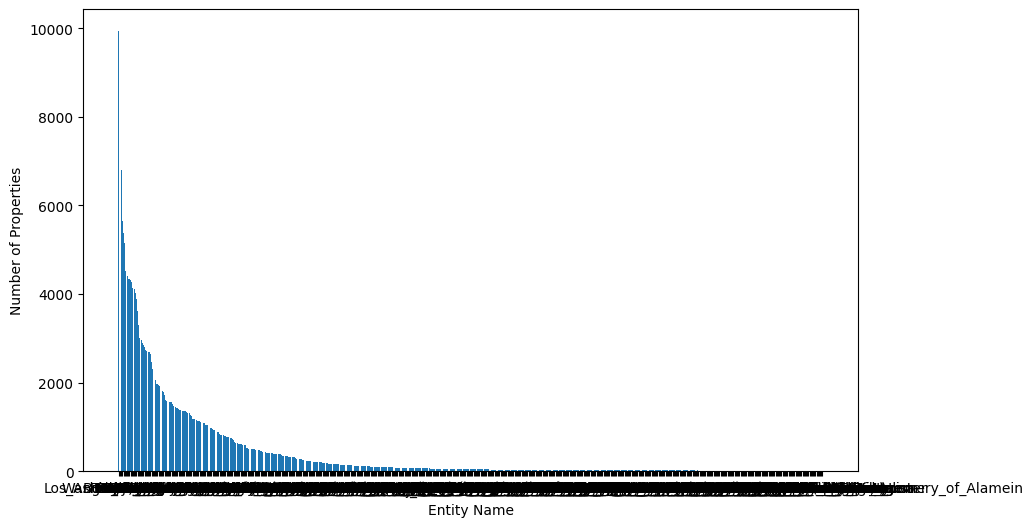

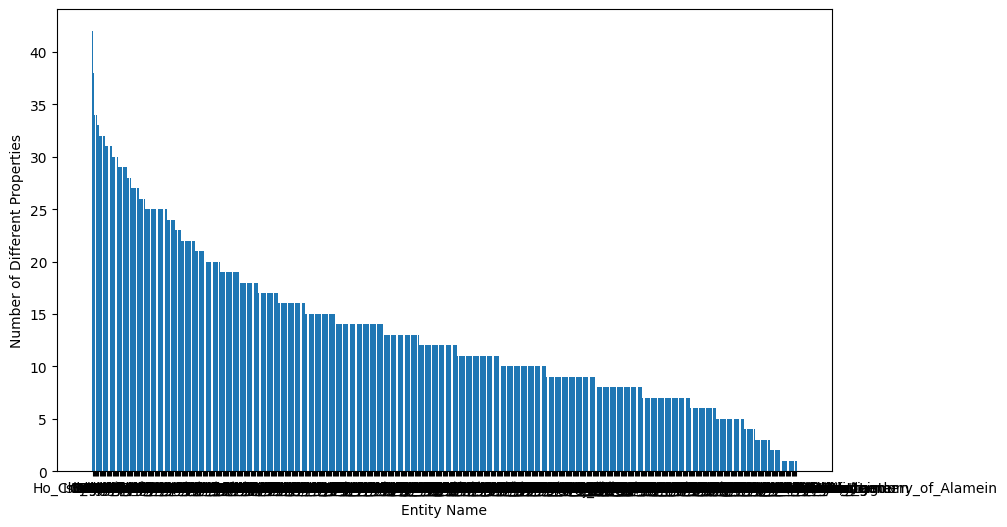

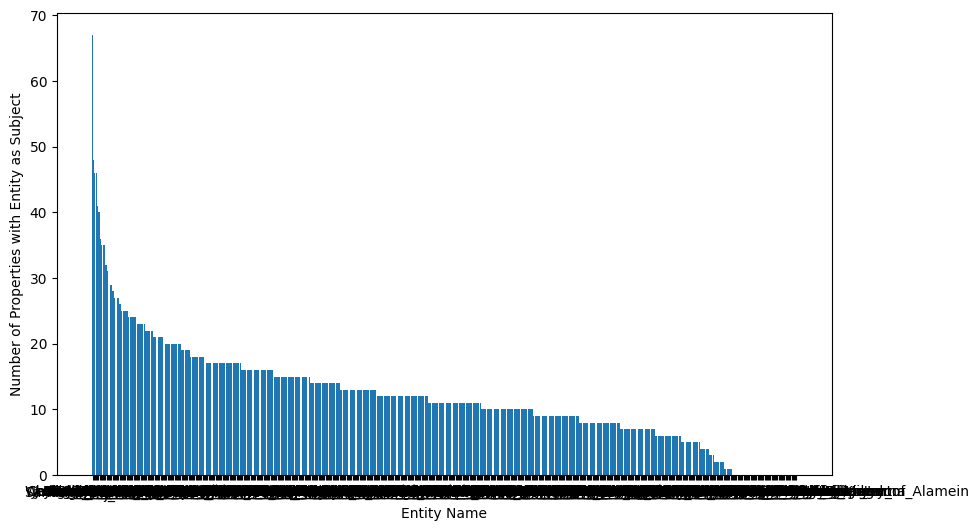

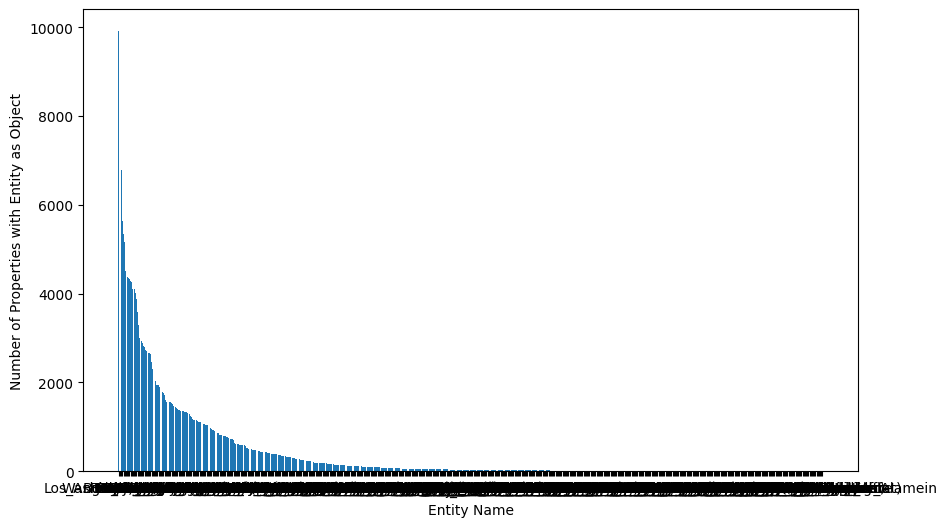

In [14]:
#@title Check triples extracted from DBpedia
import pickle
import matplotlib.pyplot as plt

# dico_input_contents_loaded should be a dico_1 with category names as keys, and a dico_2 as value.
# dico_2 should have entity_name as key, and a list of Triple Objects as value.
# Triple Objects have 3 attributes: DBsubj, DBprop, DBobj
dico_input_contents_loaded = None
if dico_input_contents == 'Made_with_this_notebook':
  with open("dico_input_contents_DBp.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)
elif dico_input_contents == 'GitHub_GREC_NEs':
  with open("/content/Build_KGs_entities/resources/dico_input_contents_DBp_GREC_NEs.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)

dico_properties = {}
dico_different_properties = {}
dico_entity_as_subj = {}
dico_entity_as_obj = {}
for category in dico_input_contents_loaded.keys():
  # print(category)
  for entity_name in dico_input_contents_loaded[category].keys():
    all_properties = []
    different_properties = []
    subj_of_properties = []
    obj_of_properties = []
    # print('  ', entity_name)
    for triple_object in dico_input_contents_loaded[category][entity_name]:
      all_properties.append(triple_object.DBprop)
      if triple_object.DBprop not in different_properties:
        different_properties.append(triple_object.DBprop)
      if triple_object.DBsubj == entity_name:
        subj_of_properties.append(triple_object.DBprop)
      if triple_object.DBobj == entity_name:
        obj_of_properties.append(triple_object.DBprop)
    dico_properties[entity_name] = len(all_properties)
    dico_different_properties[entity_name] = len(different_properties)
    dico_entity_as_subj[entity_name] = len(subj_of_properties)
    dico_entity_as_obj[entity_name] = len(obj_of_properties)
    # print(f'    {len(different_properties)} different properties')
    # print(f'    {len(subj_of_properties)} properties with {entity_name} as subject')
    # print(f'    {len(obj_of_properties)} properties with {entity_name} as object')

dico_properties_sorted = {k: v for k, v in sorted(dico_properties.items(), key=lambda item: item[1], reverse=True)}
dico_different_properties_sorted = {k: v for k, v in sorted(dico_different_properties.items(), key=lambda item: item[1], reverse=True)}
dico_entity_as_subj_sorted = {k: v for k, v in sorted(dico_entity_as_subj.items(), key=lambda item: item[1], reverse=True)}
dico_entity_as_obj_sorted = {k: v for k, v in sorted(dico_entity_as_obj.items(), key=lambda item: item[1], reverse=True)}

# Plot dico_properties dictionary using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(dico_properties_sorted.keys(), dico_properties_sorted.values())
plt.xlabel('Entity Name')
plt.ylabel('Number of Properties')
plt.show()

# Plot dico_different_properties dictionary using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(dico_different_properties_sorted.keys(), dico_different_properties_sorted.values())
plt.xlabel('Entity Name')
plt.ylabel('Number of Different Properties')
plt.show()

# Plot dico_entity_as_subj_sorted dictionary using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(dico_entity_as_subj_sorted.keys(), dico_entity_as_subj_sorted.values())
plt.xlabel('Entity Name')
plt.ylabel('Number of Properties with Entity as Subject')
plt.show()

# Plot dico_entity_as_obj_sorted dictionary using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(dico_entity_as_obj_sorted.keys(), dico_entity_as_obj_sorted.values())
plt.xlabel('Entity Name')
plt.ylabel('Number of Properties with Entity as Object')
plt.show()

In [ ]:
#@title Save triple sets in XML format: WebNLG size mirroring

## Build knowledge graphs #3: free distribution

In [ ]:
#@title Save triple set in XML format: Large DBpedia dataset
from WikipediaPage_Generator.code.utils import get_first_n_instances_of_props, create_xml, clear_folder

dico_input_contents = 'GitHub_GREC_NEs'#@param['GitHub_GREC_NEs', 'Made_with_this_notebook']

# Specifies the maximum number of occurrences of each property in the triple set
max_num_of_instances_of_prop_desired = "3" #@param[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
############### TO COMPLETE
############### TO COMPLETE
############### TO COMPLETE
############### TO COMPLETE
############### TO COMPLETE
# List here properties that cannot have 2 values (to filter bad stuff from i.e. infobox)
properties_that_can_happen_once_only = ['budget', 'gross', 'imdbId', 'length', 'runtime']
############### TO COMPLETE
############### TO COMPLETE
############### TO COMPLETE
############### TO COMPLETE
############### TO COMPLETE
import pickle

# Input data structure should be a dico_1 with category names as keys, and a dico_2 as value.
# dico_2 should have entity_name as key, and a list of Triple Objects as value.
# Triple Objects have 3 attributes: DBsubj, DBprop, DBobj
counter_datapoints = 0
dico_input_contents_loaded = None
if dico_input_contents == 'Made_with_this_notebook':
  with open("dico_input_contents_DBp.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)
elif dico_input_contents == 'GitHub_GREC_NEs':
  with open("/content/Build_KGs_entities/resources/dico_input_contents_DBp_GREC_NEs.pickle", "rb") as handle:
    dico_input_contents_loaded = pickle.load(handle)

for input_category in dico_input_contents_loaded.keys():
  print(input_category)
  folder_name = input_category+'_'+str(max_num_of_instances_of_prop_desired)
  clear_folder(os.path.join(triple2predArg, folder_name))
  # if not os.path.exists(os.path.join(triple2predArg, input_category)):
  os.makedirs(os.path.join(triple2predArg, folder_name))
  for entity_name in dico_input_contents_loaded[input_category].keys():
    # print('  ', entity_name, len(dico_input_contents_loaded[input_category][entity_name]))
    # for triple_object in dico_input_contents_loaded[category][entity]:
      # print('  ', triple_object.DBprop)
    list_triple_objects = dico_input_contents_loaded[input_category][entity_name]
    # Generate list of indices of properties selected by user (index in the list of Triple objects that contains all retrieved triples)
    properties_selected = get_first_n_instances_of_props(list_triple_objects, int(max_num_of_instances_of_prop_desired), properties_that_can_happen_once_only)
    print(f'  {entity_name}: selected {len(properties_selected)}/{len(dico_input_contents_loaded[input_category][entity_name])} properties.')

    if len(properties_selected) > 0:
      # create xml file passing the entity name to use as filename
      counter_datapoints += 1
      list_triples_text = create_xml(list_triple_objects, properties_selected, input_category, os.path.join(triple2predArg, folder_name), entity_name=entity_name, eid = counter_datapoints)

print(f'----------\n{counter_datapoints} new datapoints were created in total.')

Cities
  Abidjan: selected 40/466 properties.
  Abu_Dhabi: selected 45/386 properties.
  Accra: selected 62/1308 properties.
  Addis_Ababa: selected 55/401 properties.
  Adelaide: selected 11/1554 properties.
  Ahmedabad: selected 57/502 properties.
  Algiers: selected 59/707 properties.
  Almaty: selected 52/523 properties.
  Amman: selected 53/605 properties.
  Amsterdam: selected 28/2810 properties.
  Ankara: selected 61/1125 properties.
  Antananarivo: selected 40/160 properties.
  Asmara: selected 37/127 properties.
  Astana: selected 37/159 properties.
  Asunción: selected 50/626 properties.
  Athens: selected 30/2127 properties.
  Auckland: selected 19/2307 properties.
  Aşgabat: selected 7/20 properties.
  Baghdad: selected 55/1047 properties.
  Baku: selected 25/1352 properties.
  Bamako: selected 45/347 properties.
  Bangalore: selected 26/921 properties.
  Bangkok: selected 29/1367 properties.
  Bangui: selected 28/113 properties.
  Banjul: selected 31/120 properties.
  Bass

## Process output XMLs (group, etc.)
Stratified sampling info 100 inputs:
1:20.8 - 2:19.6 - 3:19.6 - 4:17.2 - 5:12 - 6:6.4 - 7:4.4

In [ ]:
#@title Put all XMLs in the same file for sampling
import glob

paths_folders_categories = glob.glob('/content/XML/*')
with open('/content/XML/D2T-1-FA_SemAccExperiments.xml', 'w') as f:
  f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
  f.write('<benchmark>\n')
  f.write('  <entries>\n')
  for path_folder_category in sorted(paths_folders_categories):
    list_XMLS_for_category = glob.glob(os.path.join(path_folder_category, '*.xml'))
    for XML in sorted(list_XMLS_for_category):
      with open(XML, 'r') as file:
        XML_lines = file.readlines()
        for line in XML_lines:
          if not line.startswith('<') and not line.startswith('  <'):
            f.write(line)
  f.write('  </entries>\n')
  f.write('</benchmark>\n')
print('Created XML file!')